# Прикладная математика
# Лабораторная работа №4
# Методы решения СЛАУ
# Кумирова, Харлунин M32021, Дистеров M32061

In [ ]:
import numpy as np
import math
from dataclasses import dataclass
from collections import namedtuple
from copy import deepcopy
from scipy.linalg import hilbert
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
from scipy.sparse import csr_matrix as sparse_row_matrix

mpl.style.use(['ggplot'])


@dataclass
class SLE:
    A: np.ndarray
    F: np.ndarray

    def dim(self):
        return len(self.F)

    def compute(self, x_vec: np.ndarray):
        return self.A @ x_vec.T

    def cond(self):
        return np.linalg.cond(self.A)

Result = namedtuple('Result', ['X', 'iter'])

def MSE(Y, YH):
    return np.square(Y - YH).mean()

# Метод Гаусса с выбором ведущего элемента
Метод Гаусса - это алгоритм для решения систем линейных алгебраических уравнений (СЛАУ). Он основан на приведении расширенной матрицы системы к ступенчатому виду с последующим обратным ходом. Процесс состоит из двух этапов: прямого хода (приведение матрицы к ступенчатому виду) и обратного хода (получение решения СЛАУ).

Основная идея метода Гаусса с выбором ведущего элемента состоит в том, чтобы выбирать ведущий элемент (элемент, с которым выполняются операции преобразования строк) среди всех элементов столбца таким образом, чтобы он имел наибольшую абсолютную величину. Это позволяет уменьшить ошибки округления и улучшить устойчивость алгоритма.



In [ ]:
def gauss_with_pivot(sle: SLE):
    A = sle.A.tolist()
    b = sle.F.tolist()
    n = len(A)
    M = [row.copy() for row in A]
    for i, x in enumerate(M):
        x.append(b[i])
    #Прямой ход
    for k in range(n):
        for i in range(k, n):
            if abs(M[i][k]) > abs(M[k][k]):
                M[k], M[i] = M[i], M[k]
        for j in range(k + 1, n):
            q = float(M[j][k]) / M[k][k]
            for m in range(k, n + 1):
                M[j][m] -= q * M[k][m]
    #Обратный ход
    x = [0 for _ in range(n)]
    x[n - 1] = float(M[n - 1][n]) / M[n - 1][n - 1]
    for i in range(n - 1, -1, -1):
        z = 0
        for j in range(i + 1, n):
            z += float(M[i][j]) * x[j]
        x[i] = float(M[i][n] - z) / M[i][i]
    return np.array(x)

Этот метод обладает большей устойчивостью, по сравнению с обычным методом Гаусса, потому что в каждом шаге выбирается элемент с наибольшей абсолютной величиной. Это уменьшает вероятность возникновения больших ошибок округления.

Метод Гаусса с выбором главного элемента является прямым методом, то есть он может дать точное решение за конечное количество шагов (в пределах ошибок округления). Это делает его предпочтительным для систем небольшого размера.

Однако этот метод требует дополнительного места для хранения преобразованной матрицы и дополнительного времени на перестановку строк. Это может быть проблемой для очень больших систем.

# $LU$ разложение с разреженно-строчными матрицами
$LU$-разложение является общим методом разложения матрицы на произведение двух матриц - одной нижнетреугольной ($L$, lower) и одной верхнетреугольной ($U$, upper). Если дана квадратная матрица $A$, то $LU$-разложение стремится найти $L$ и $U$ такие, что:

$A = L \cdot U$

Как только мы получили $LU$-разложение матрицы, мы можем использовать его для решения системы линейных уравнений вида:

$A \cdot x = b$

с помощью двух последовательных операций обратной подстановки. Вначале решаем систему:

$L \cdot y = b$

а затем систему:

$U \cdot x = y$

Таким образом, находим решение исходной системы $A \cdot x = b$

In [ ]:
def lu_decomposition(sle: SLE):
    A = sle.A.tolist()
    n = len(A)
    L = [[0] * n for _ in range(n)]
    U = [[0] * n for _ in range(n)]
    for i in range(n):
        L[i][i] = 1
        for j in range(i, n):
            s1 = sum(U[k][j] * L[i][k] for k in range(i))
            U[i][j] = A[i][j] - s1
        for j in range(i, n):
            if i == j:
                L[j][i] = 1
            else:
                s2 = sum(U[k][i] * L[j][k] for k in range(i))
                L[j][i] = (A[j][i] - s2) / U[i][i]
    return sparse_row_matrix(np.array(L)), sparse_row_matrix(np.array(U))

def lu_solve(sle: SLE, L: sparse_row_matrix, U: sparse_row_matrix):
    b = sle.F.tolist()
    n = L.shape[0]
    y = [0 for _ in range(n)]
    x = [0 for _ in range(n)]
    for i in range(n):
        row_l = L.getrow(i)
        y[i] = b[i] - (row_l * y)[:i].sum()
    for i in range(n - 1, -1, -1):
        row_u = U.getrow(i)
        x[i] = (y[i] - (row_u * x)[i+1:n].sum()) / row_u.getcol(i).data[0]
    return np.array(x)

$LU$-разложение дает высокую эффективность при решении множества систем уравнений с одной и той же матрицей, но разными векторами правой части. После выполнения $LU$-разложения можно быстро решать каждую систему, применяя только обратный ход метода Гаусса.

$LU$-разложение является прямым методом и может дать точное решение за конечное количество шагов (в пределах ошибок округления).

Однако $LU$-разложение требует дополнительного пространства для хранения матриц $L$ и $U$, а также дополнительного времени на их вычисление. Также $LU$-разложение может быть не возможно без перестановки строк для некоторых матриц (в таком случае используют $LU$-разложение с частичным выбором).

Если матрица системы является разреженной, то $LU$-разложение может привести к "заполнению" ненулевыми значениями многих изначально нулевых элементов, что снижает эффективность использования разреженных структур данных.

$LU$-разложение может быть неустойчивым для некоторых типов матриц (например, для матриц с очень большими или очень маленькими элементами).

In [ ]:
L, U = lu_decomposition(sle)

x = lu_solve(sle, L, U)

print("Решение системы:", x)

# Реализация итерационного метода решения СЛАУ (на выбор)

Итерационные методы – это методы
последовательных приближений.
В них необходимо задать некоторое
приближённое решение – начальное
приближение. После этого с помощью
некоторого алгоритма проводится один цикл
вычислений, называемый итерацией.
В результате итерации находят новое
приближение. (Организуется циклический вычислительный
процесс.)
Итерации проводятся до получения
решения с требуемой точностью.
В качестве первого приближения обычно
принимают нулевые значения, т.е. $x^{(1)} = x^{(2)} =...= x^{(n)} = 0$

#### Критерий останова итерационного процесса: $\max(|x^{(k+1)}-x^{(k)}|) < \delta$

Если система не является плохо обусловленной, то в
качестве критерия окончания итерационного процесса можно
использовать условие малости невязки

Преимущества итерационных методов:
- требуют хранения в памяти машины не всей
матрицы системы, а лишь нескольких векторов
с n компонентами;
- Погрешности окончательных результатов при
использовании итерационных методов не
накапливаются, поскольку точность
вычислений в каждой итерации определяется
результатами предыдущей итерации и
практически не зависит от ранее выполненных
вычислений.

## Метод Зейделя

$$
\begin{equation*}
 \begin{cases}
   x_1^{(k+1)} = \beta_1 + \alpha_{12}x_2^{(k)} + \alpha_{13}x_3^{(k)} + ...+ \alpha_{1n}x_n^{(k)}
   \\
   ...
   \\
   x_i^{(k+1)} = \beta_i + \alpha_{i1}x_1^{(k+1)} + \alpha_{i2}x_2^{(k+1)} + ...+ \alpha_{ii}x_i^{(k)} + ...+ \alpha_{in}x_n^{(k)}
   \\
   ...
   \\
   x_n^{(k+1)} = \beta_n + \alpha_{n1}x_1^{(k+1)} + \alpha_{n2}x_2^{(k+1)} + ...+ \alpha_{nn}x_n^{(k)}
 \end{cases}
\end{equation*}
$$

Метод Зейделя является некоторой модификацией метода простых итераций (метода Якоби), при которой в приближении $x^{(k+1)}$ уже учитываются вычисленные компоненты вектора

### Достаточное условие сходимости

Для сходимости итерационного процесса
достаточно, чтобы модули диагональных
коэффициентов для каждого уравнения системы
были не меньше сумм модулей всех остальных
коэффициентов (преобладание диагональных
элементов):

> $|a_{ii}| \geq \sum_{i!=j} |a_{ij}|$

In [ ]:
def seidel_iter(sle: SLE, max_delta=0.001, max_iter=1000):
    def seidel_prepare(sle: SLE):
        for i in range(sle.dim()):
            sle.F[i] /= sle.A[i][i]
            sle.A[i] /= sle.A[i][i]
        return sle

    def seidel_compute_xi(i, sle: SLE, x: np.ndarray):
        x_i = sle.F[i]
        for j in range(sle.dim()):
            if j == i: continue
            x_i -= sle.A[i][j] * x[j]
        return x_i

    x_init = np.zeros(sle.dim(), dtype="float64")
    sle = seidel_prepare(deepcopy(sle))

    for it in range(1, max_iter+1):
        x_next = deepcopy(x_init)
        for i in range(sle.dim()):
            x_next[i] = seidel_compute_xi(i, sle, x_next)

        if max(abs(x_next-x_init)) < max_delta or np.isnan(max(abs(x_next-x_init))):
            break

        x_init = x_next

    return Result(x_next, it)

```
A = np.array([[10,1,1],
              [2, 10, 1],
              [2,2,10]], dtype='float64')
F = np.array([12, 13, 14], dtype='float64')

seidel_iter(SLE(A,F))

Result(X=array([0.99997669, 0.99999937, 1.00000479]), iter=4)
```

## Выводы
- Метод Зейделя дает большой выигрыш в точности, так как, во-первых, метод Зейделя существенно уменьшает число умножений и делений, во-вторых, позволяет накапливать сумму произведений без записи промежуточных результатов.
- Метод Зейделя являются абсолютно сходящимся, т.е. для него нет необходимости вводить достаточные условия сходимости в отличие от метода простой итерации.
- Обычно данный метод дает лучшую сходимость, чем метод простой итерации. Кроме того, метод Зейделя может оказаться более удобным при программировании, так как при вычислении $x^{(k+1)}_i$ нет необходимости хранить значения $x^{(k)}_{<i}$

# Исследование реализованных методов на системах с матрицами $A^{(k)}$, число обусловленности которых регулируется за счет изменения меры диагонального преобладания

Внедиагональные элементы выбираются случайным образом из множества
> $a_{ij} \in \{0,-1,-2,-3,-4\}$

а диагональные элементы определяются из условия
> $a_{ii} = -\sum_{i\ne j} a_{ij}$ ```if i > 1```

> $a_{ii} = -\sum_{i\ne j} a_{ij} + 10^k$ ```if i == 1```

Для исследования работы методов решается СЛАУ вида
> $A^{(k)}x^k=F^k$

где $F^k$ определяется как вектор $(1,2,...,n)^T$ для того, чтобы можно было сравнить точное и приближенное решение

In [ ]:
def generate_diagonal_dominance(n, k):
    A = np.random.choice(np.array([0.0,-1.0,-2.0,-3.0,-4.0], dtype='float128'), size=(n,n))

    for i in range(n):
        A[i][i] = -sum(A[i]) if i != 0 else -sum(A[i]) + 10 ** k

    F = np.array([float(i) for i in range(1, n+1)], dtype='float128')

    return SLE(A, F)

In [ ]:
generate_diagonal_dominance(5, 5)

```
SLE(A=array([[ 1.00011e+05, -2.00000e+00, -4.00000e+00, -1.00000e+00,
        -4.00000e+00],
       [ 0.00000e+00,  4.00000e+00, -1.00000e+00,  0.00000e+00,
        -3.00000e+00],
       [-1.00000e+00, -3.00000e+00,  8.00000e+00,  0.00000e+00,
        -4.00000e+00],
       [-2.00000e+00,  0.00000e+00, -2.00000e+00,  8.00000e+00,
        -4.00000e+00],
       [-3.00000e+00, -1.00000e+00, -1.00000e+00,  0.00000e+00,
         5.00000e+00]]), F=array([1., 2., 3., 4., 5.]))
```

# Оценка зависимости числа обусловленности и точности полученного решения в зависимости от параметра диагонального преобладания $k$

Число обусловленности выражает меру зависимости решения от правой части
> $\mu(A) = ||A|| \cdot	 ||A^{-1}||$

чем меньше $\mu(A)$, тем лучше обусловлена система, а значит, лучше решается с помощью вышеизложенных численных методов

## Описание экспериментов
#### число экспериментов
#### $repeats = 200$
#### размер матрицы
#### $n = 10$
#### метод для подсчета числа обусловленности - ```numpy.linalg.cond```
#### формула для подсчета невязки - $MSE = \frac{1}{n}\sum_i(Y_i-\hat{Y_i})^2$

## Зависимость числа обусловленности
| k  | cond - $\min$ | cond - $\max$ |
|----|:--------------|:--------------|
| 1  | 8             | 39            |
| 2  | 23            | 67            |
| 3  | 187           | 509           |
| 4  | 1805          | 5119          |
| 5  | 16839         | 64822         |
| 6  | 181466        | 690082        |
| 7  | 1713021       | 8363199       |
| 8  | 18286553      | 73097474      |
| 9  | 175578727     | 486547782     |
| 10 | 1785079484    | 5635124101    |

## Зависимость точности


### Метод Гаусса с выбором ведущего элемента
#### Параметры эксперимента и результаты в прилож. A


In [ ]:
resamples = 200
n = 20

for k in range(1, 11):
    @dataclass
    class benchmark:
        sle: SLE = None
        cond: float = None

        solution: np.ndarray = None
        precision_metric: float = None

    test_data = [benchmark(generate_diagonal_dominance(n,k)) for _ in range(resamples)]

    for i in range(resamples):
        test_data[i].cond = test_data[i].sle.cond()
        test_data[i].solution = gauss_with_pivot(test_data[i].sle)

    multiplications = [None] * resamples
    mses = np.array([0.0] * resamples)
    for i in range(resamples):
        multiplications[i] = test_data[i].sle.compute(test_data[i].solution)
        test_data[i].precision_metric = mses[i] = MSE(multiplications[i], test_data[i].sle.F)

    print(f"{k}:")
    print(mses.min(), mses.max())

    plt.hist(mses)
    plt.title(f"GAUSS_TEST, k={k},\n {n}x{n}, {resamples} resamples")

    plt.xlabel("$\hat{MSE}$ = " + f"{np.mean(mses)}")

    plt.axvline(np.median(mses), linestyle='--', color='xkcd:deep purple')
    plt.savefig(f'gauss_{k}.png', dpi=600, facecolor='xkcd:heather')
    plt.show()

### Метод LU-разложения
#### Параметры эксперимента и результаты в прилож. B



In [ ]:
resamples = 200
n = 20

for k in range(1, 11):
    @dataclass
    class benchmark:
        sle: SLE = None
        cond: float = None

        solution: np.ndarray = None
        precision_metric: float = None

    test_data = [benchmark(generate_diagonal_dominance(n,k)) for _ in range(resamples)]

    for i in range(resamples):
        test_data[i].cond = test_data[i].sle.cond()
        test_data[i].solution = lu_solve(test_data[i].sle, *lu_decomposition(test_data[i].sle))

    multiplications = [None] * resamples
    mses = np.array([0.0] * resamples)
    for i in range(resamples):
        multiplications[i] = test_data[i].sle.compute(test_data[i].solution)
        test_data[i].precision_metric = mses[i] = MSE(multiplications[i], test_data[i].sle.F)

    print(f"{k}:")
    print(mses.min(), mses.max())

    plt.hist(mses)
    plt.title(f"LU_TEST, k={k},\n {n}x{n}, {resamples} resamples")

    plt.xlabel("$\hat{MSE}$ = " + f"{np.mean(mses)}")

    plt.axvline(np.median(mses), linestyle='--', color='xkcd:deep purple')
    plt.savefig(f'LU__{k}.png', dpi=600, facecolor='xkcd:heather')
    plt.show()

### Метод Зейделя
#### Параметры эксперимента и результаты в прилож. С




In [ ]:
resamples = 200
n = 20
MIN_DELTA = 1e-9
MAX_ITER = 5000

for k in range(1, 11):

    @dataclass
    class benchmark:
        sle: SLE = None
        cond: float = None

        solution: np.ndarray = None
        iters: int = None

        precision_metric: float = None

    test_data = [benchmark(generate_diagonal_dominance(n,k)) for _ in range(resamples)]

    for i in range(resamples):
        test_data[i].cond = test_data[i].sle.cond()
        solution_i = seidel_iter(test_data[i].sle, MIN_DELTA, MAX_ITER)
        test_data[i].solution, test_data[i].iters = solution_i.X, solution_i.iter

    multiplications = [None] * resamples
    mses = [None] * resamples
    for i in range(resamples):
        multiplications[i] = test_data[i].sle.compute(test_data[i].solution)
        mses[i] = MSE(multiplications[i], test_data[i].sle.F)
        test_data[i].precision_metric=mses[i]

    print(f"{k}:")

    iters = np.array([td.iters for td in test_data])
    conds = np.array([td.cond for td in test_data])
    print(f"mean iter: {iters.mean()} ; median iter: {np.median(iters)} ; max/min: {iters.max()}/{iters.min()}")

    plt.hist(iters)
    plt.title(f"SEIDEL_TEST, k={k},\n {n}x{n}, {resamples} resamples\niters: ({iters.min()}; {iters.max()}), cond: ({int(conds.min())}; {int(conds.max())})")

    plt.xlabel(f"min_delta = {MIN_DELTA}," + " $\hat{MSE}$_actual = " + f"{np.mean(mses)}")

    plt.axvline(np.median(mses), linestyle='--', color='xkcd:deep purple')
    plt.savefig(f'seidel_{k}.png', dpi=600, facecolor='xkcd:heather')
    plt.show()

# Аналогичные исследования на матрицах Гильберта

Формула, согласно которой строятся матрицы Гильберта:
$$a_{ij}=\frac{1}{i+j-1}, \; i,j=1,\dots,n$$
где $n$ - размерность матрицы

Для исследования работы методов решается СЛАУ вида
$$𝐴^{(𝑘)}𝑥^𝑘=𝐹^𝑘 $$
где  $𝐹^𝑘$  определяется как вектор  $(1,2,...,𝑛)^𝑇 $ для того, чтобы можно было сравнить точное и приближенное решение

In [ ]:
def generate_hilbert_matrix(n):
      A = np.array([[1 / (i + j + 1) for j in range(n)] for i in range(n)], dtype='float128')

      F = np.array([float(i) for i in range(1, n+1)], dtype='float128')

      return SLE(A, F)

In [ ]:
generate_hilbert_matrix(5)

```
SLE(A=array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111]]), F=array([1., 2., 3., 4., 5.]))
```

## Зависимость числа обусловленности от размерности матрицы

In [ ]:
for i in range(1,11):
    print(i, int(generate_hilbert_matrix(i).cond()))



| n  | cond           |
|----|:---------------|
| 1  | 1              |
| 2  | 19             |
| 3  | 524            |
| 4  | 15513          |
| 5  | 476607         |
| 6  | 14951058       |
| 7  | 475367356      |
| 8  | 15257575538    |
| 9  | 493153756446   |
| 10 | 16024416992541 |

## Зависимость точности от размерности матрицы

### Описание экспериментов
#### метод для подсчета числа обусловленности - ```numpy.linalg.cond```
#### формула для подсчета невязки - $MSE = \frac{1}{n}\sum_i(Y_i-\hat{Y_i})^2$

### Метод Гаусса с выбором ведущего элемента

In [ ]:
for n in range(1,16):
    @dataclass
    class benchmark:
        sle: SLE = None
        cond: float = None

        solution: np.ndarray = None
        precision_metric: float = None

    test_data = benchmark(generate_hilbert_matrix(n))

    test_data.cond = test_data.sle.cond()
    test_data.solution = gauss_with_pivot(test_data.sle)


    test_data.precision_metric = MSE(test_data.sle.compute(test_data.solution), test_data.sle.F)

    print(f"{n}: {test_data.precision_metric}")

```
1: 0.0
2: 0.0
3: 1.6829032644714918e-29
4: 6.462348535570529e-27
5: 1.34416849539867e-25
6: 3.308722450212111e-24
7: 3.4032573773610283e-22
8: 4.0657581468206416e-20
9: 2.439454888092385e-18
10: 9.71445146547012e-17
11: 1.8571003321002618e-15
12: 2.0842586915629605e-13
13: 1.7122030289311414e-12
14: 4.677401323403631e-10
15: 4.980312458731836e-13
```

###Метод LU-разложения

In [ ]:
for n in range(1,16):
    @dataclass
    class benchmark:
        sle: SLE = None
        cond: float = None

        solution: np.ndarray = None
        precision_metric: float = None

    test_data = benchmark(generate_hilbert_matrix(n))

    test_data.cond = test_data.sle.cond()
    test_data.solution = lu_solve(test_data.sle, *lu_decomposition(test_data.sle))


    test_data.precision_metric = MSE(test_data.sle.compute(test_data.solution), test_data.sle.F)

    print(f"{n}: {test_data.precision_metric}")

```
1: 0.0
2: 0.0
3: 0.0
4: 8.077935669463161e-28
5: 1.34416849539867e-25
6: 1.5440704767656518e-23
7: 7.865305938789932e-22
8: 4.0657581468206416e-20
9: 4.20128341838133e-18
10: 2.2759572004815707e-16
11: 6.620966401400933e-15
12: 2.0842586915629605e-13
13: 1.5008302293258915e-11
14: 4.5831751092708015e-12
15: 2.349527979580065e-13
```

###Метод Зейделя

In [ ]:
MIN_DELTA = 1e-9
MAX_ITER = 5000
for n in range(1,16):
    @dataclass
    class benchmark:
        sle: SLE = None
        cond: float = None

        solution: np.ndarray = None
        precision_metric: float = None

        iters: int = None

    test_data = benchmark(generate_hilbert_matrix(n))

    test_data.cond = test_data.sle.cond()

    solution_i = seidel_iter(test_data.sle, MIN_DELTA, MAX_ITER)
    test_data.solution, test_data.iters = solution_i.X, solution_i.iter

    test_data.precision_metric = MSE(test_data.sle.compute(test_data.solution), test_data.sle.F)

    print(f"{n}: {test_data.precision_metric}")

```
1: 0.0
2: 8.18264680924892e-20
3: 2.9679093780699267e-20
4: 2.750413961187319e-06
5: 0.0022058807689960018
6: 0.004204932085678848
7: 0.002255858813829248
8: 0.0031143491974332943
9: 0.008597601774312184
10: 0.015711518182032713
11: 0.02182271115021049
12: 0.024945878636388946
13: 0.024431050754246317
14: 0.02158587445576855
15: 0.019142239667831965
```

Полученные данные показывают, что обусловленность матриц Гильберта возрастает с ростом их размерности $n$, что указывает на то, что такие матрицы имеют плохую обусловленность и приводят к большим ошибкам при решении систем линейных уравнений.

Метод Гаусса и $LU$-разложение демонстрируют схожие значения ошибок, которые увеличиваются вместе с размерностью матрицы, что указывает на чувствительность обоих методов к высокому числу обусловленности и также на то, что они дают сопоставимую точность в решении системы уравнений.

Хотя ошибка метода Зейделя увеличивается с увеличением размерности матрицы, она все еще остается сопоставимой с ошибками методов Гаусса и $LU$-разложения. Это объясняется тем, что метод Зейделя является итерационным и может достичь высокой точности, несмотря на высокое число обусловленности матрицы.

Матрицы Гильберта имеют плохую обусловленность, что приводит к большим ошибкам при решении систем линейных уравнений. Метод Зейделя остается стабильным для разных размерностей матрицы, но все еще допускает ошибки.

# Сравнение между собой прямых и итерационных методов по эффективности методов в зависимости от размеров $n$ матрицы

Размеры матрицы:
$$n \in \{10, 50, 10^2, 10^3, 10^4, 10^5\}$$

## Сравнение прямых и итерационных методов по эффективности методов от размеров $n$ матрицы

In [ ]:
def generate_random_matrix(n):
    return np.random.rand(n, n)

def measure_time(method, sle):
    start_time = time.time()
    x = method(sle)
    end_time = time.time()
    return x, end_time - start_time

matrix_sizes = [10, 50, 100, 200,300,400,500,600,700,800,900,1000]

direct1_times = []
direct2_times = []
iterative_times = []

for n in matrix_sizes:
    A = generate_random_matrix(n)
    F = np.array([float(i) for i in range(1, n+1)])

    sle = SLE(A, F)

    _, direct1_time = measure_time(gauss_with_pivot, sle)
    direct1_times.append(direct1_time)

    _, direct2_time = measure_time(lambda A: lu_solve(A, *lu_decomposition(sle)), sle)
    direct2_times.append(direct2_time)

    _, iterative_time = measure_time(lambda A: seidel_iter(A, 0.1, 1000), sle)
    iterative_times.append(iterative_time)


plt.plot(matrix_sizes, direct1_times, color='xkcd:heather', label='gauss method')
plt.plot(matrix_sizes, direct2_times, color='xkcd:sage', label='LU method')
plt.plot(matrix_sizes, iterative_times, color='xkcd:light grey green', label='seidel method ($\max \delta = 0.1$, $\max n = 1000$)')
plt.xlabel('matrix size')
plt.ylabel('time (seconds)')
plt.title('comparison of direct and iterative methods')
plt.legend()
plt.savefig("result.png", dpi=600)
plt.grid(True)
plt.show()

Из полученных результатов можно сделать вывод о том, что с ростом размерности матрицы, время выполнения прямого метода (Гаусса) возрастает гораздо медленнее, чем время выполнения итерационного метода (Зейделя).

Метод $LU$-разложения наиболее эффективный для решения обычных матриц. Метод Гаусса – наименее эффективный. Метод Зейделя может не сходиться для некоторых систем линейных уравнений. Как уже было отмечено ранее он сходится быстрее только для матриц, удовлетворяющих условию строгой диагональной доминированности или условию положительной определенности.

### Результаты запуска в pycharm (слишком тяжело для google collab'a)

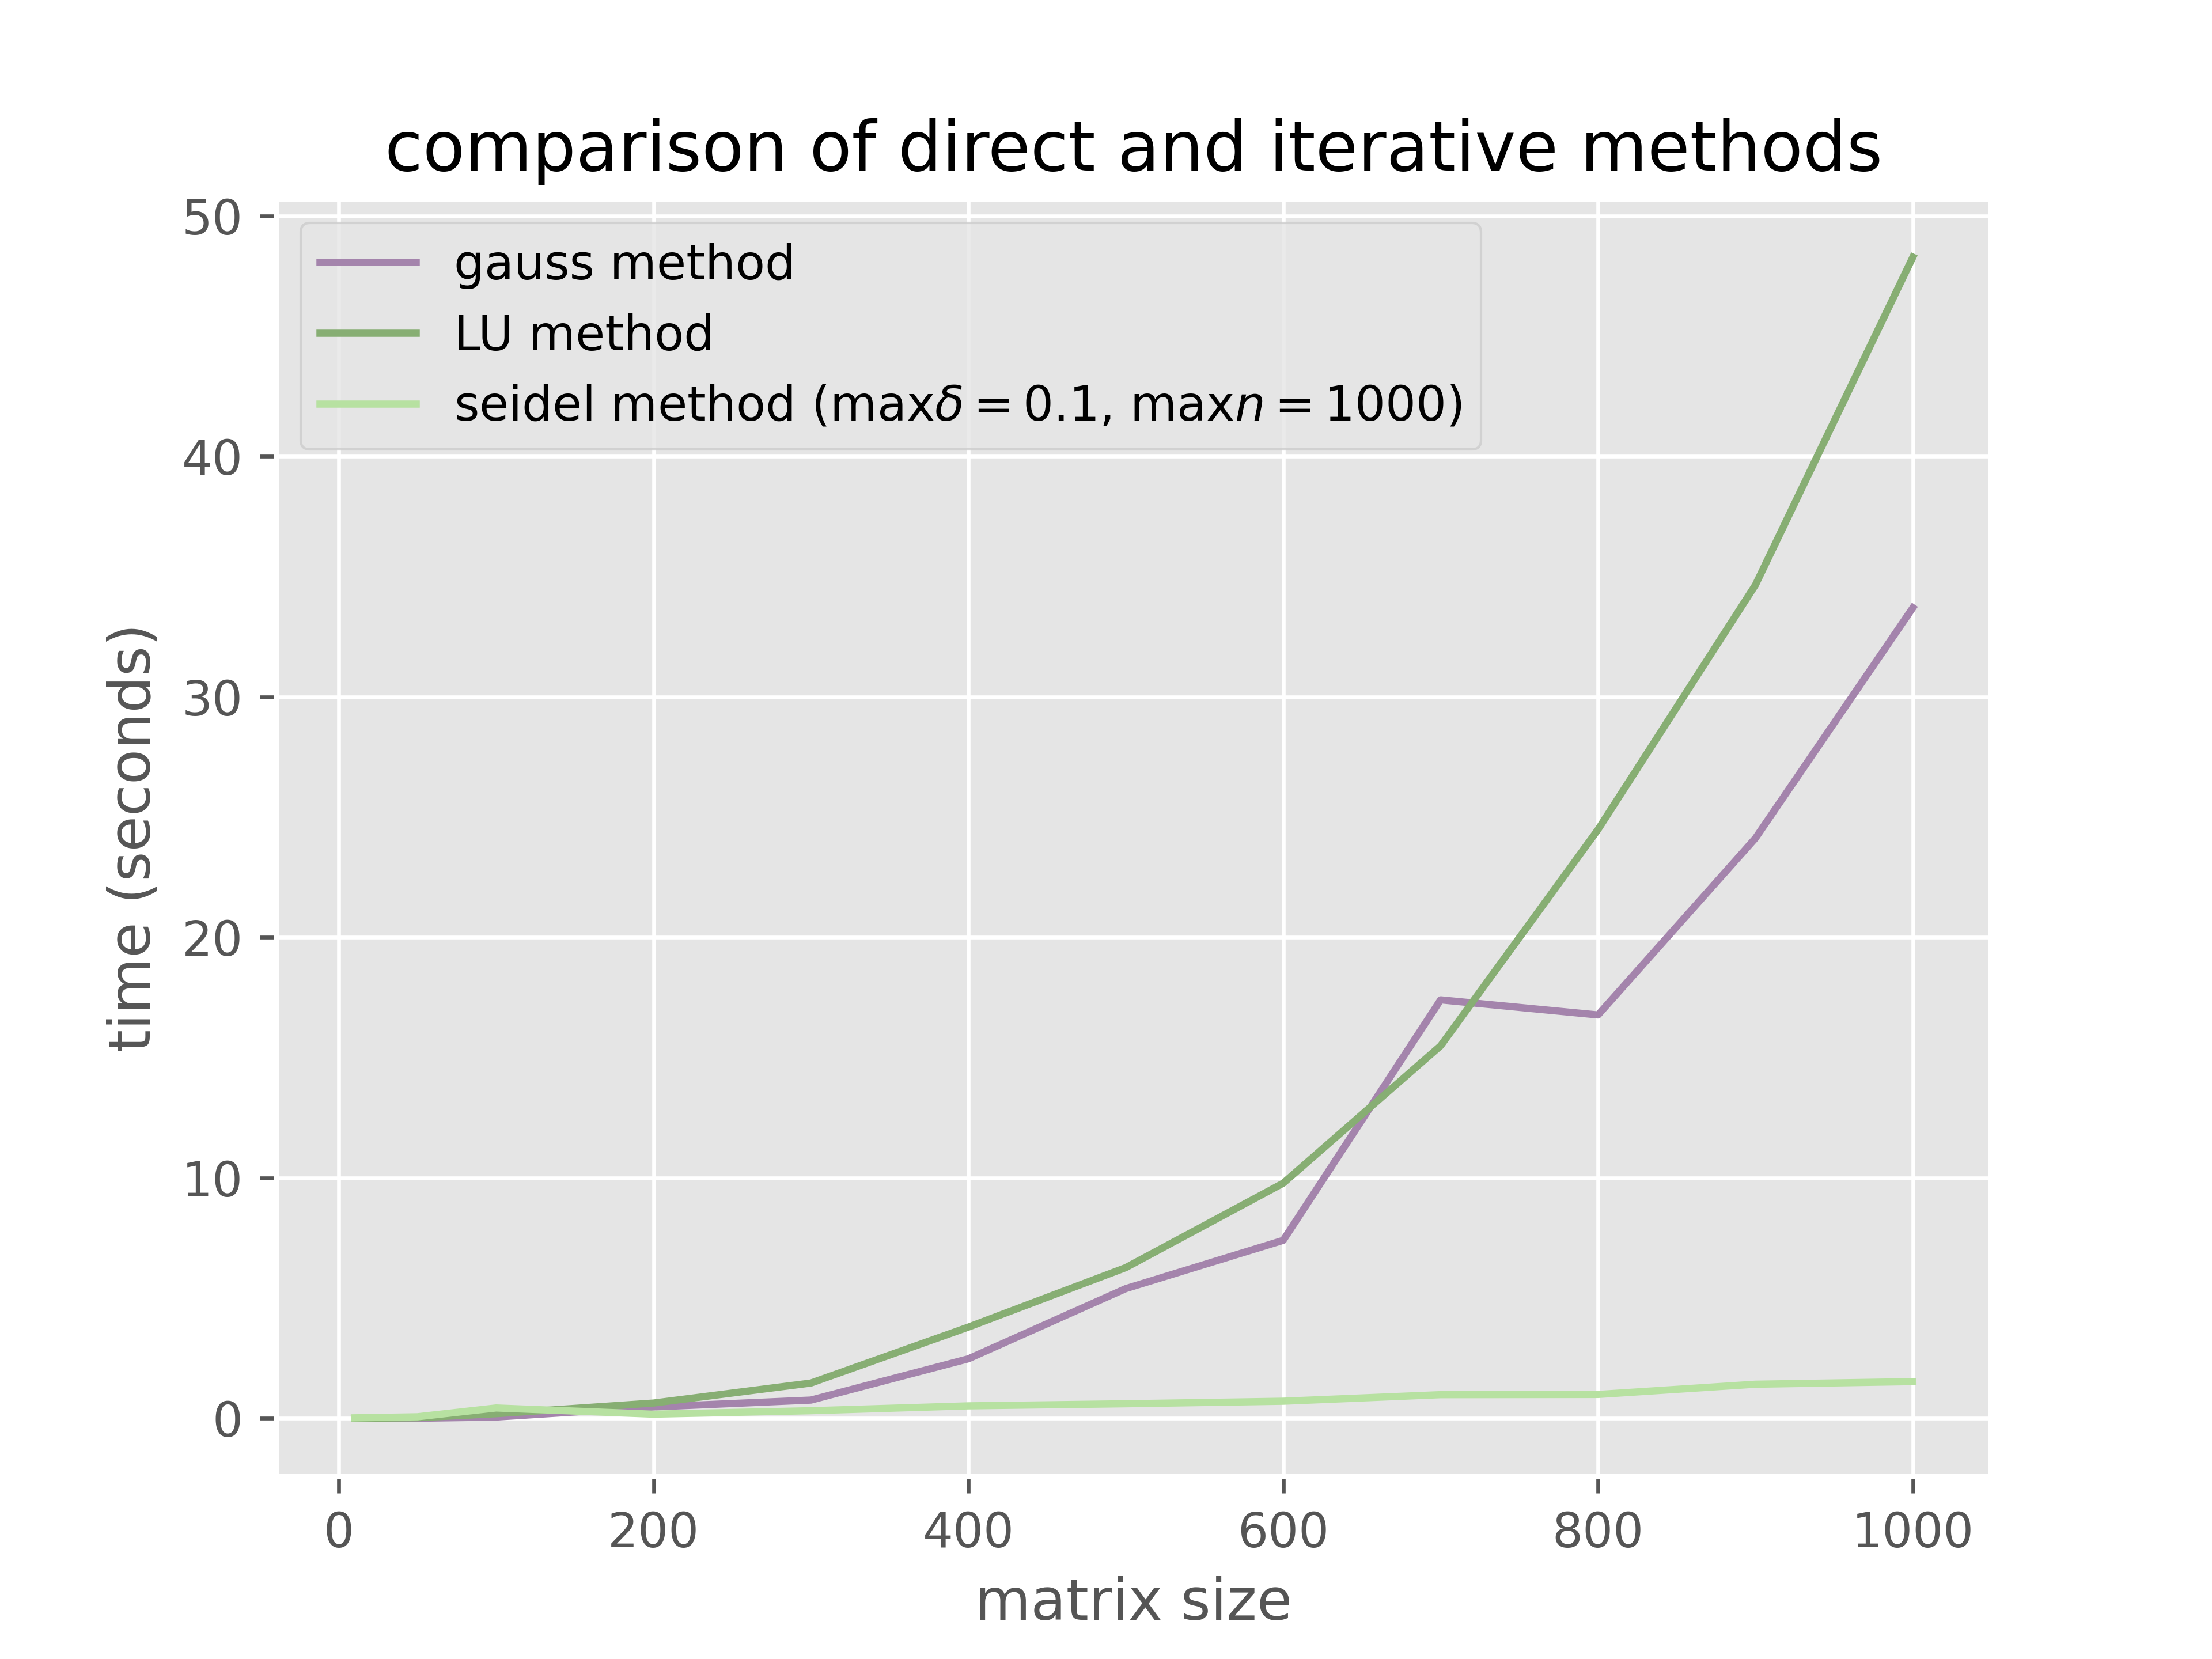

# Источники
1. [ТПУ | Численные методы решения уравнений | Материалы для бакалавров](https://portal.tpu.ru/SHARED/b/BGA/bio/bachelors/Tab/Numerica_meth_eq_solution.pdf)
2. Финансовый университет при Правительстве РФ | Учебно-метод. пособие по дисциплине "Компьютерный практикум"
3. [Исследование свойств матрицы Гильберта и причин её плохой обусловленности](https://cyberleninka.ru/article/n/issledovanie-svoystv-matritsy-gilberta-i-prichin-ee-plohoy-obuslovlennosti/viewer)